# On particle filters applied to electricity load forecasting


PyMC tuto

https://pymc-devs.github.io/pymc/tutorial.html#fitting-the-model-with-mcmc

http://sdsawtelle.github.io/blog/output/mcmc-in-python-with-pymc.html
    

In [1]:
import pandas as pd
import numpy as np
import numpy.random as npr
import matplotlib as mtp
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import truncnorm
import scipy.stats as stats
from scipy.stats import invgamma

In [2]:
import pymc
from pymc import MCMC

### Parameters

In [3]:
n0=365 #Initialisaion sample
M=10^5 #number of particles

In [176]:
"""
#truncated normal
lower = 0
upper = np.inf
mu = 0
sigma = 10^8
N = 1
sigma_s = np.asscalar(stats.truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma,loc=mu,scale=sigma,size=N))
g_h = np.asscalar(stats.truncnorm.rvs((-np.inf-mu)/sigma,(0-mu)/sigma,loc=mu,scale=sigma,size=N))
s0 = np.asscalar(stats.truncnorm.rvs((np.inf-mu)/sigma,(0-mu)/sigma,loc=mu,scale=sigma,size=N))
g_c = np.asscalar(stats.truncnorm.rvs((np.inf-mu)/sigma,(0-mu)/sigma,loc=mu,scale=sigma,size=N))

/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:4838: RuntimeWarning: invalid value encountered in log
  self._logdelta = np.log(self._delta)


In [267]:
#u_h=npr.normal(14,1)
#N_daytype=1
#p=np.ones(N_daytype)
#k_day=np.asscalar(npr.dirichlet(p,1))
#sigma2, sigma2_s0, sigma2_g0, sigma2_s, sigma2_g = invgamma.rvs(a=0.01,scale=0.01,size=5)
delta_c = 5 #to be updated
T_h = 12 #to be updated

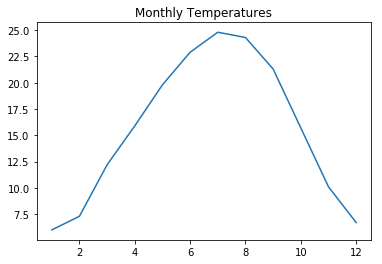

In [279]:
#simulate temperatures
temp_month=np.array([6,7.3,12.2,15.9,19.8,22.9,24.8,24.3,21.3,15.7,10.1,6.7])  #monthly max temp in Paris
month=['jan','fev','mar','av','may','juin','juil','aou','sep','oct','nov','dec']
days_month=np.array([31,29,31,30,31,30,31,31,30,31,30,31])
i=0
temp_={}
for m in month:
    temp_[m]=np.repeat(temp_month[i],days_month[i])
    i=i+1
temp_month_mean=np.ones(0)
for m in month:
    temp_month_mean=np.concatenate((temp_month_mean,temp_[m]),axis=0)
plt.plot(range(1,13),temp_month)
plt.title('Monthly Temperatures')

In [8]:
# T_heat: only temperatures over u_heat
#T_h=np.copy(temp_month_mean)
#T_h[T_h < u_h]=u_h

#delta_cool=np.copy(temp_month)
#delta_cool[delta_cool >= u_h]=u_h

### Data

In [301]:
#n0=365 days of eletricity load for initialization
path_AG="/Users/antoinegrelety/iCloud Drive (archive)/Desktop/MS Data Science/S1_MCMC/Projet/"
df=pd.read_csv(path_AG+"cdc_conso.csv",sep=";")

In [302]:
df.head()

,Date - Heure,Date,Heure,Consommation (MW),Qualite donnee
0,2009-06-06T06:00:00+02:00,2009-06-06,06:00,35984,Définitive
1,2009-06-06T09:00:00+02:00,2009-06-06,09:00,43188,Définitive
2,2009-06-06T11:30:00+02:00,2009-06-06,11:30,46959,Définitive
3,2009-06-06T12:30:00+02:00,2009-06-06,12:30,48622,Définitive
4,2009-06-06T20:30:00+02:00,2009-06-06,20:30,42578,Définitive


In [303]:
df['Qualite donnee'].value_counts()

Définitive       157824
Intermédiaire     14592
Name: Qualite donnee, dtype: int64

In [304]:
df=df.sort_values(by=['Date'])
df['Date - Heure'][df['Qualite donnee']=="Intermédiaire"][:5]
#Valeurs intermédiaires à partir de 2017

142358    2017-01-01T08:30:00+01:00
158630    2017-01-01T05:00:00+01:00
169265    2017-01-01T04:00:00+01:00
169266    2017-01-01T07:00:00+01:00
169267    2017-01-01T07:30:00+01:00
Name: Date - Heure, dtype: object

In [305]:
#On se concentre d'abord sur une année afin d'initialiser le filtre
df=df[(df.Date >'2016-01-01') & (df.Date <'2017-01-01')]

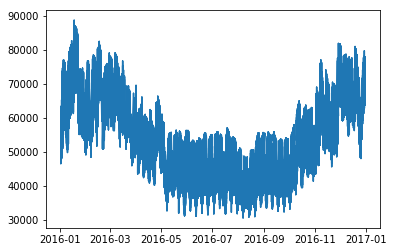

In [306]:
plt.plot_date(df.Date,df['Consommation (MW)'],fmt='-')
plt.show()

In [307]:
y_n=df['Consommation (MW)']
y_n=y_n[:100]
y_n=y_n.values

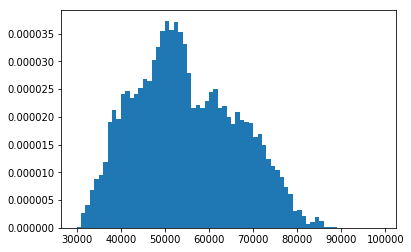

In [287]:
bins=range(30000,100000,1000)
plt.hist(df['Consommation (MW)'],normed=True,bins=bins)
plt.show()

### Definition of MCMC initial model

1. Sample $X_0^{j} \sim \mu(x_0)$

In [308]:
delta_c = 5 #to be updated
T_h = 12 #to be updated
sigma2=invgamma.rvs(a=0.01,scale=0.01)

In [309]:
sigma2

6.3063945110661977e+32

In [310]:
#v=pymc.Normal("v",0,np.asscalar(sigma2),size=len(y_n))
s0=pymc.TruncatedNormal("s0",mu=0,tau=1/(10^8),a=0,b=np.inf)
gc=pymc.TruncatedNormal("gc",mu=0,tau=1/(10^8),a=0,b=np.inf)
g0=pymc.TruncatedNormal("g0",mu=0,tau=1/(10^8),a=0,b=np.inf)
g0_h=pymc.TruncatedNormal("g0_h",mu=0,tau=1/(10^8),a=-np.inf,b=0)
u_h=pymc.Normal("u_h",mu=14,tau=1)
k_day=pymc.Dirichlet(name="k_day",theta=[1,1])

/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/pymc/utils.py:435: RuntimeWarning: divide by zero encountered in log
  return np.where(y > 0, np.log(y), -np.inf)


In [311]:
@pymc.deterministic(plot=False)
def x_season(s0=s0,k_day=k_day):
    out=np.empty(len(y_n))
    out.fill(s0*np.asscalar(k_day))
    return(out)

@pymc.deterministic(plot=False)
def x_heat(g0_h=g0_h,T_h=T_h,u_h=u_h):
    out=np.empty(len(y_n))
    out.fill(g0_h*(T_h-u_h)*max(u_h,T_h))
    return(out)

@pymc.deterministic(plot=False)
def x_cool(g_c=gc,detla_c=delta_c):
    out=np.empty(len(y_n))
    out.fill(g_c*delta_c)
    return(out)

@pymc.deterministic(plot=False)
def x(x_season=x_season, x_heat=x_heat, x_cool=x_cool):
    out=np.empty(len(y_n))
    out=x_season+x_heat+x_cool
    return(out)


In [312]:
y=pymc.Normal("y",mu=x,tau=sigma2,value=y_n,observed=True)

In [313]:
model=pymc.Model([s0,gc,g0,g0_h,u_h,k_day,x_season,x_heat,x_cool,x,y])

In [314]:
y.parents

{'mu': <pymc.PyMCObjects.Deterministic 'x' at 0x1240c6ef0>,
 'tau': 6.3063945110661977e+32}

In [315]:
x.children

{<pymc.distributions.new_dist_class.<locals>.new_class 'y' at 0x1382de908>}

In [316]:
print(x.value)
#Problème: a l'état initial les v.a. prior sont fixes et x prend toujours la même valeur...

[ 137.16182643  137.16182643  137.16182643  137.16182643  137.16182643
  137.16182643  137.16182643  137.16182643  137.16182643  137.16182643
  137.16182643  137.16182643  137.16182643  137.16182643  137.16182643
  137.16182643  137.16182643  137.16182643  137.16182643  137.16182643
  137.16182643  137.16182643  137.16182643  137.16182643  137.16182643
  137.16182643  137.16182643  137.16182643  137.16182643  137.16182643
  137.16182643  137.16182643  137.16182643  137.16182643  137.16182643
  137.16182643  137.16182643  137.16182643  137.16182643  137.16182643
  137.16182643  137.16182643  137.16182643  137.16182643  137.16182643
  137.16182643  137.16182643  137.16182643  137.16182643  137.16182643
  137.16182643  137.16182643  137.16182643  137.16182643  137.16182643
  137.16182643  137.16182643  137.16182643  137.16182643  137.16182643
  137.16182643  137.16182643  137.16182643  137.16182643  137.16182643
  137.16182643  137.16182643  137.16182643  137.16182643  137.16182643
  137.

In [317]:
print(y.value) #Electricity load

[ 52975.  49417.  55737.  57237.  61223.  55522.  60935.  60962.  47741.
  46599.  56223.  58010.  58265.  62191.  58321.  59989.  60075.  58954.
  48821.  51509.  52726.  55462.  57349.  47970.  60339.  60921.  58154.
  59637.  62407.  63353.  55621.  51520.  52236.  57308.  50896.  52313.
  54574.  56687.  57965.  58683.  46528.  49009.  63251.  46945.  56053.
  56593.  50505.  47300.  51538.  61528.  64325.  65180.  63655.  56866.
  54093.  60236.  54405.  58899.  65289.  59405.  50184.  60018.  62048.
  56968.  57536.  48928.  50612.  49854.  49440.  58578.  60198.  61020.
  58554.  60619.  59868.  57407.  57213.  57856.  55494.  52612.  48724.
  48464.  48359.  55362.  55827.  51983.  61481.  62771.  58860.  62613.
  61664.  59023.  56864.  53524.  48009.  51397.  66450.  65780.  63758.
  69039.]


In [318]:
sampler=MCMC(model)

In [319]:
sampler.sample(iter=100*len(y_n), burn=10*len(y_n), thin=10) 

/Users/antoinegrelety/anaconda3/lib/python3.6/site-packages/pymc/utils.py:435: RuntimeWarning: divide by zero encountered in log
  return np.where(y > 0, np.log(y), -np.inf)


 [-----------------100%-----------------] 10000 of 10000 complete in 8.9 sec

In [320]:
s_tr = sampler.trace("x")

In [321]:
s_tr[1,1]

56549.560235568024

In [322]:
sampler.trace("x")[0:20].shape  # Just look at the first few values

(20, 100)

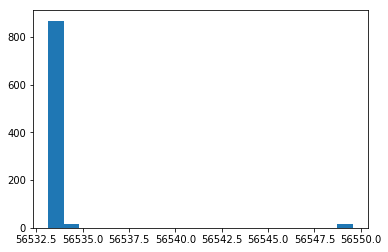

In [323]:
%matplotlib inline
plt.hist(s_tr[:,1],bins=20)
plt.show()

Plotting u_h
Plotting g0_h
Plotting s0
Plotting k_day_0
Plotting gc
Plotting g0


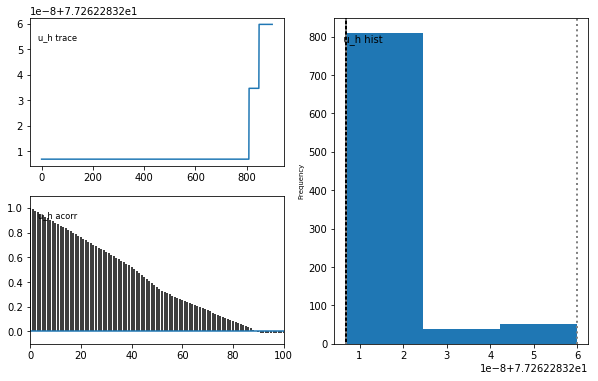

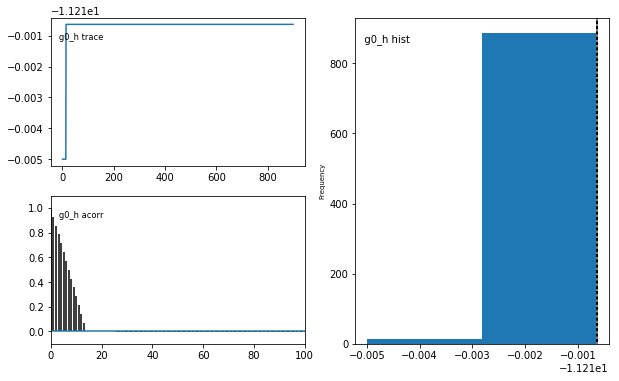

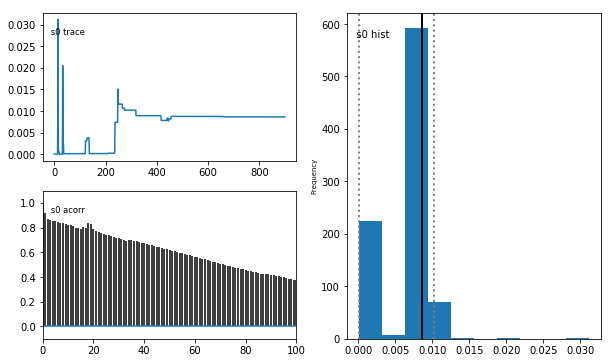

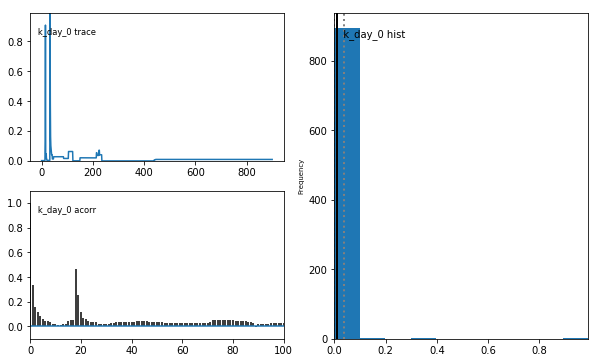

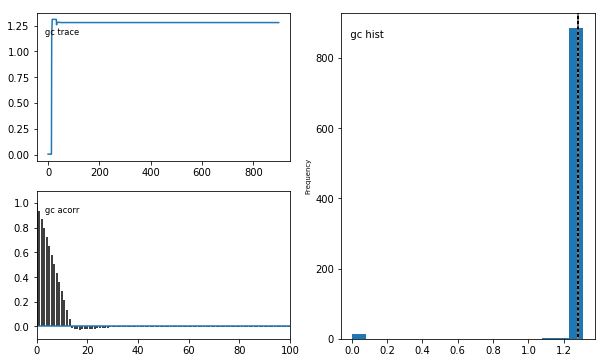

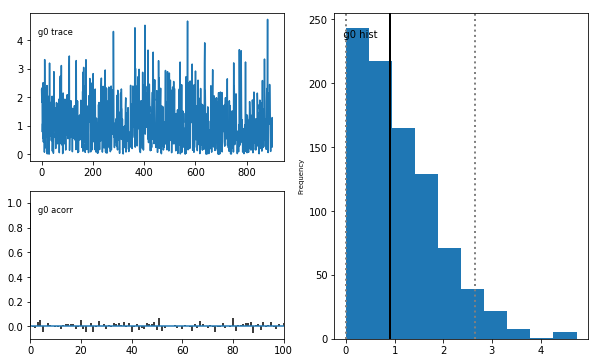

In [324]:
pymc.Matplot.plot(sampler)